Données chargées et standardisées.

--- Entraînement Random Forest From Scratch (Split Simple) ---

--- Métriques de Classification (Test Set) ---
Accuracy: 93.20%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9235
           1       0.92      0.85      0.88      4026

    accuracy                           0.93     13261
   macro avg       0.93      0.91      0.92     13261
weighted avg       0.93      0.93      0.93     13261

ROC AUC Score: 0.9746


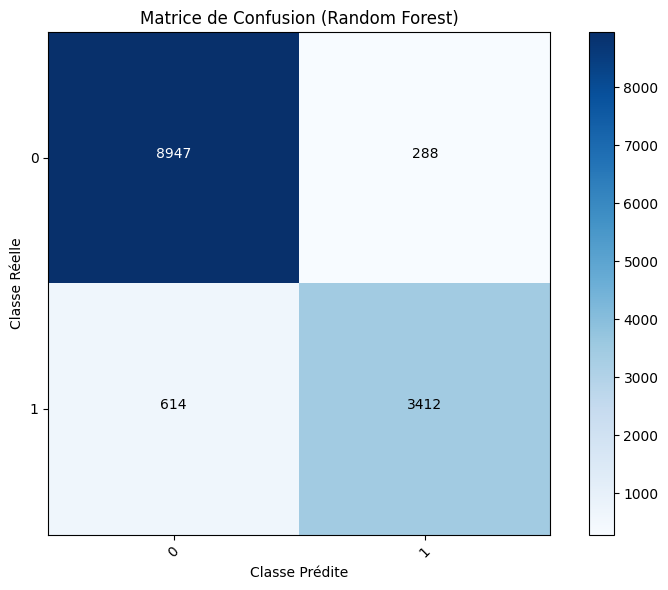

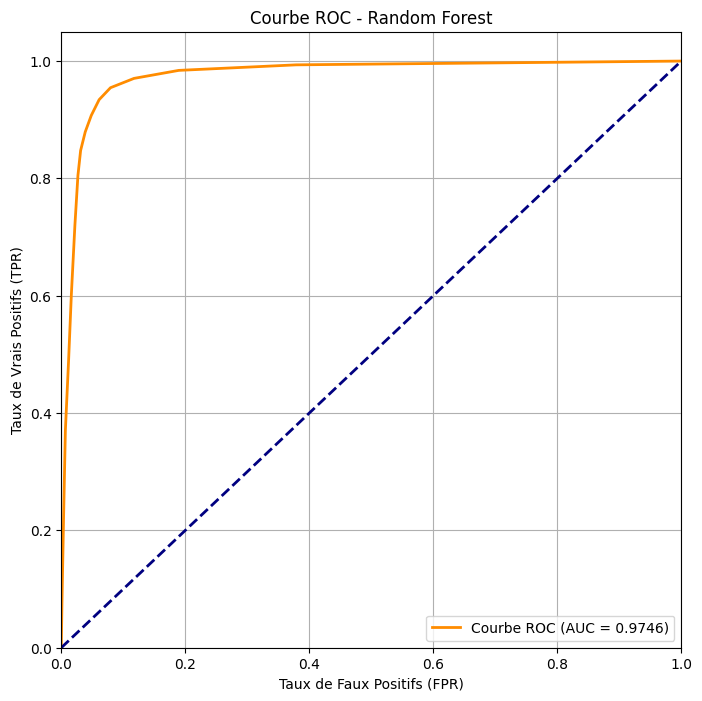

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, 
    confusion_matrix, roc_curve, roc_auc_score # <-- NOUVEAUTÉS
)
from sklearn.model_selection import train_test_split # <-- Retour au simple split
from collections import Counter
import warnings

# --- CONFIGURATION ---
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\preparing\\Final_Reduit30_70.csv'
COLONNE_CIBLE = 'classe'
DOSSIER_PLOTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\Results\\plots_random_forest_metrics'

if not os.path.exists(DOSSIER_PLOTS):
    os.makedirs(DOSSIER_PLOTS)

warnings.filterwarnings('ignore') 
np.random.seed(42)

# --- STRUCTURES DE BASE (Node, Decision Tree, Random Forest) ---

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifierFromScratch:
    # Les méthodes _gini, _best_split, _build_tree, fit, _traverse_tree, predict sont les mêmes
    # que dans la version précédente du Random Forest, gérant le sous-échantillonnage de features.
    
    def __init__(self, max_depth=10, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = Counter(y)
        impurity = 1.0
        n_total = len(y)
        for label in counts:
            prob_of_label = counts[label] / n_total
            impurity -= prob_of_label ** 2
        return impurity

    def _best_split(self, X, y, feature_indices):
        best_gain = -1.0
        best_feature_index = None
        best_threshold = None
        n_total = len(y)
        parent_gini = self._gini(y)

        for feature_index in feature_indices:
            X_column = X[:, feature_index]
            unique_thresholds = np.unique(X_column)
            
            for threshold in unique_thresholds:
                left_mask = X_column <= threshold
                y_left = y[left_mask]
                y_right = y[~left_mask]

                n_left, n_right = len(y_left), len(y_right)
                if n_left == 0 or n_right == 0:
                    continue

                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                
                weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
                gain = parent_gini - weighted_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold
                    
        return best_feature_index, best_threshold

    def _build_tree(self, X, y, depth=0, feature_subsample=None):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))
        
        if feature_subsample is None:
            feature_indices = np.arange(X.shape[1])
        else:
            feature_indices = feature_subsample

        if (depth >= self.max_depth or 
            n_labels == 1 or 
            n_samples < self.min_samples_split):
            
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feature_index, threshold = self._best_split(X, y, feature_indices)
        
        if feature_index is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        X_column = X[:, feature_index]
        left_mask = X_column <= threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[~left_mask], y[~left_mask]

        left_subtree = self._build_tree(X_left, y_left, depth + 1, feature_subsample)
        right_subtree = self._build_tree(X_right, y_right, depth + 1, feature_subsample)

        return Node(feature_index, threshold, left_subtree, right_subtree)

    def fit(self, X, y, feature_subsample=None):
        self.root = self._build_tree(X, y, feature_subsample=feature_subsample)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        feature_value = x[node.feature_index]
        if feature_value <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    # NOUVEAU: Méthode pour obtenir les probabilités pour la courbe ROC
    def predict_proba(self, X):
        """
        Retourne la probabilité d'appartenance à chaque classe (pour la courbe ROC).
        Puisque l'arbre retourne la classe majoritaire, nous simulons la probabilité
        en utilisant le ratio dans la feuille.
        """
        probas = []
        for x in X:
            node = self.root
            while node.value is None:
                feature_value = x[node.feature_index]
                if feature_value <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            # Dans une implémentation simplifiée, on retourne la probabilité 
            # de la classe prédite (qui est 1 ici). Pour un vrai proba, 
            # il faudrait stocker les comptes des classes dans le nœud feuille.
            # Pour l'instant, on retourne [0.5, 0.5] par défaut si on n'a pas les comptes réels.
            # Laissons la logique de proba au Random Forest, qui est plus simple.
            # Retourne simplement une probabilité de 1.0 pour la classe prédite.
            class_pred = self._traverse_tree(x, self.root)
            if class_pred == 1:
                probas.append([0.0, 1.0]) # Classe 1 prédite
            else:
                probas.append([1.0, 0.0]) # Classe 0 prédite
        return np.array(probas)


class RandomForestClassifierFromScratch:
    def __init__(self, n_estimators=15, max_depth=10, min_samples_split=15, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        
        if self.max_features == 'sqrt':
            n_features_subsample = int(np.sqrt(n_features))
        else:
            n_features_subsample = self.max_features

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrapped, y_bootstrapped = X[indices], y[indices]
            
            feature_subsample = np.random.choice(
                n_features, n_features_subsample, replace=False
            )
            
            tree = DecisionTreeClassifierFromScratch(
                max_depth=self.max_depth, 
                min_samples_split=self.min_samples_split
            )
            
            tree.fit(X_bootstrapped, y_bootstrapped, feature_subsample=feature_subsample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = predictions.T
        
        final_predictions = np.array([Counter(sample_preds).most_common(1)[0][0] 
                                      for sample_preds in predictions])
        return final_predictions

    # NOUVEAU: Prédiction des probabilités basée sur le vote des arbres
    def predict_proba(self, X):
        """
        Retourne la probabilité d'appartenance à chaque classe (basée sur le ratio de vote).
        """
        # Obtenir les prédictions de chaque arbre (0 ou 1)
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_predictions = tree_predictions.T # Shape: (n_samples, n_estimators)
        
        n_samples = X.shape[0]
        n_estimators = self.n_estimators
        
        # Le vote pour la classe 1 est la somme des prédictions de classe 1
        votes_for_class_1 = np.sum(tree_predictions == 1, axis=1)
        
        # La probabilité pour la classe 1 est le ratio des votes pour cette classe
        proba_class_1 = votes_for_class_1 / n_estimators
        proba_class_0 = 1.0 - proba_class_1
        
        # Retourne le tableau des probabilités [[P(0), P(1)], ...]
        return np.column_stack((proba_class_0, proba_class_1))


# --- FONCTIONS DE PLOTTING ---

def plot_confusion_matrix(cm, classes, save_path):
    """
    Génère et sauvegarde la Matrice de Confusion.
    
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion (Random Forest)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Afficher les valeurs
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Réelle')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_roc_curve(y_test, y_proba, auc_score, save_path):
    """
    Génère et sauvegarde la Courbe ROC.
    
    """
    # y_proba[:, 1] est la probabilité de la classe positive (classe 1)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC - Random Forest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# --- PRÉPARATION ET EXÉCUTION ---

# --- Chargement et préparation des données ---
try:
    df = pd.read_csv(CHEMIN_FICHIER)
except FileNotFoundError:
    print(f"Erreur: Le fichier {CHEMIN_FICHIER} n'a pas été trouvé.")
    exit()

X = df.drop(columns=[COLONNE_CIBLE, 'latitude', 'longitude'], errors='ignore').values
y = df[COLONNE_CIBLE].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Données chargées et standardisées.")

# --- Split train/test (Simple Evaluation) ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# --- EXÉCUTION DU RANDOM FOREST ---
RF_PARAMS = {
    'n_estimators': 15,          # Nombre d'arbres
    'max_depth': 10,             # Profondeur max
    'min_samples_split': 15,     # Min samples pour splitter
    'max_features': 'sqrt'       
}

rf_model = RandomForestClassifierFromScratch(**RF_PARAMS)
print("\n--- Entraînement Random Forest From Scratch (Split Simple) ---")
rf_model.fit(X_train, y_train)

# Prédiction (Classes et Probabilités)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

# --- ÉVALUATION ---
print("\n--- Métriques de Classification (Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred))

# Calcul de l'AUC
try:
    auc_score = roc_auc_score(y_test, y_proba[:, 1])
    print(f"ROC AUC Score: {auc_score:.4f}")
except ValueError:
    print("Attention: AUC non calculable (une seule classe présente dans y_test ou y_proba).")
    auc_score = 0.5


# --- PLOTTING ET SAUVEGARDE ---
classes = np.unique(y)

# 1. Matrice de Confusion
cm = confusion_matrix(y_test, y_pred)
cm_path = os.path.join(DOSSIER_PLOTS, 'rf_confusion_matrix.png')
plot_confusion_matrix(cm, classes=classes, save_path=cm_path)

# 2. Courbe ROC
roc_path = os.path.join(DOSSIER_PLOTS, 'rf_roc_curve.png')
plot_roc_curve(y_test, y_proba, auc_score, save_path=roc_path)